## 0. Load all needed inputs

### 0.1 Original input into transformer layer

In [1]:
import torch

/Users/sharmilisrinivasan/miniconda3/envs/llm_from_scratch_py312/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [4]:
original_input = torch.load("intermediate_values/final_embedding.pt")
print(original_input[0,:,:])
original_input.shape  # batch_size * in_seq_len * emd_dim

tensor([[ 2.3231, -0.3746,  2.6221,  2.2130, -1.3411,  0.1152, -0.6356, -1.3310,
         -0.4394,  2.4190],
        [ 0.5539, -5.1864, -0.5007,  1.0695, -0.8989, -1.4327, -0.4214,  1.9148,
          1.2416,  0.7608],
        [-2.2256, -0.2482,  0.4517, -1.5689,  0.4506, -0.1861,  1.5037, -1.0158,
         -0.2976, -2.1102],
        [-0.0212, -0.4272,  2.1284, -0.9909, -0.2254, -0.0528,  0.5645,  0.5093,
          0.2662,  2.1440],
        [ 0.3954, -0.0420, -0.1249, -2.8000,  0.8817,  2.2713,  1.8423, -0.6637,
         -2.0547,  1.2039],
        [-1.6732, -0.2235, -0.5283,  1.7224, -1.0452,  0.9322, -1.4510,  0.5735,
         -0.7763,  0.3509],
        [-0.8276,  1.5135,  0.4042,  0.4883, -2.3238, -0.6278,  1.0873,  2.3286,
         -0.1649,  0.0505]], grad_fn=<SliceBackward0>)


/var/folders/5c/l1syhclx3zl_4b_g5t_hl9tc0000gn/T/ipykernel_51180/3567984795.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_input = torch.load("intermediate_val

torch.Size([3, 7, 10])

### 0.2 Masked Multi Head Attention output from last step

In [5]:
mmha_results = torch.load("intermediate_values/multi_head_attention_output.pt")
print(mmha_results[0,:,:])
mmha_results.shape  # batch_size * in_seq_len * emd_dim

tensor([[ 0.0686,  0.0946, -0.1032, -0.3049,  0.1845, -0.6650, -0.0950,  0.0933,
          0.1256,  0.4077],
        [-0.1120,  0.0212, -0.2409, -0.4646,  0.1852, -0.4753, -0.1658, -0.0010,
          0.0245,  0.5964],
        [ 0.1395,  0.2258, -0.2484, -0.1080,  0.1302, -0.4635, -0.2763, -0.3367,
          0.1170,  0.1561],
        [-0.1825, -0.0942, -0.2303, -0.0520,  0.0081, -0.2128, -0.3513, -0.1295,
          0.1816,  0.4317],
        [-0.0668, -0.0139, -0.2622, -0.0702,  0.0203, -0.2649, -0.3682, -0.2020,
          0.1497,  0.4001],
        [-0.1409,  0.0574, -0.1783,  0.0957, -0.1992, -0.1520, -0.3703, -0.0358,
          0.1776,  0.2311],
        [-0.2890,  0.0599, -0.1943, -0.0436, -0.1696, -0.0907, -0.3540, -0.0270,
          0.1453,  0.4124]], grad_fn=<SliceBackward0>)


/var/folders/5c/l1syhclx3zl_4b_g5t_hl9tc0000gn/T/ipykernel_51180/2048667199.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mmha_results = torch.load("intermediate_value

torch.Size([3, 7, 10])

## 1. Dropout

In [7]:
import torch.nn as nn

In [8]:
drop_rate = 0.0  # Keeping it zero. Can be tried with smaller prob number
dropout = nn.Dropout(drop_rate)

In [9]:
result = dropout(mmha_results)
result.shape  # batch_size * in_seq_len * emd_dim

torch.Size([3, 7, 10])

## 2. Add Original input back

In [10]:
result = result + original_input
result.shape  # batch_size * in_seq_len * emd_dim

torch.Size([3, 7, 10])

## 3. Save intermediate result to add back later

In [11]:
intermediate_result = result

## 4. Layer Norm 2
- Normalise features within a layer (not across batch)
- Mean and variance are calculated for all activations in a layer
- These are scaled and shifted to have standard normal distribution (mean=0; variance=1)
- Handles problems of Internal covariate shift

#### Terminologies
1. Activations = Outputs of the neurons
2. Internal covariate shift = During training as each layer takes inputs from previuous layers and the input distribution keeps changing as each layer is learning. This leads to slow converges

#### Formula
### output = [scale * (input - mean)/ sqrt(variance + epsilon)] + shift
* mean = mean across activations
* variance = (Std_dev)^2 = Variance across activations
* epsilon = small constant to avoid division by zero
* scale, shift = learnable parameters

In [12]:
mean = result.mean(dim=-1, keepdim=True)  # Dim=-1 => Along Embedding size
print(mean)
mean.shape  # batch_size * in_seq_len * 1

tensor([[[ 0.5377],
         [-0.3532],
         [-0.5911],
         [ 0.3263],
         [ 0.0231],
         [-0.2633],
         [ 0.1378]],

        [[ 0.5377],
         [ 0.3765],
         [-1.1401],
         [ 0.9000],
         [ 0.3751],
         [ 0.6361],
         [ 0.7257]],

        [[-0.1260],
         [ 0.2923],
         [-0.7807],
         [ 0.4756],
         [ 0.3511],
         [ 0.2700],
         [ 0.5711]]], grad_fn=<MeanBackward1>)


torch.Size([3, 7, 1])

In [14]:
var = result.var(dim=-1, keepdim=True, unbiased=False)  # Turning off Unbiased avoids division by zero 
print(var)
var.shape # batch_size * in_seq_len * 1

tensor([[[2.4688],
         [3.8146],
         [1.1658],
         [1.1080],
         [2.2457],
         [1.2891],
         [1.6557]],

        [[2.4688],
         [1.7185],
         [2.8186],
         [2.0912],
         [1.5746],
         [2.7213],
         [3.4701]],

        [[2.3252],
         [1.1997],
         [1.3506],
         [1.8483],
         [0.5771],
         [1.6271],
         [2.2101]]], grad_fn=<VarBackward0>)


torch.Size([3, 7, 1])

In [15]:
epsilon = 1e-5
norm_result = (result - mean)/torch.sqrt(var + epsilon)
print(norm_result[0,:,:])
norm_result.shape  # batch_size * in_seq_len * emd_dim

tensor([[ 1.1800, -0.5204,  1.2609,  0.8722, -1.0783, -0.6921, -0.8072, -1.1300,
         -0.5419,  1.4568],
        [ 0.4071, -2.4638, -0.1988,  0.4906, -0.1846, -0.7961, -0.1198,  1.1607,
          0.8291,  0.8757],
        [-1.3846,  0.5267,  0.7356, -1.0056,  1.0854, -0.0542,  1.6841, -0.7052,
          0.3802, -1.2624],
        [-0.5035, -0.8054,  1.4931, -1.3008, -0.5165, -0.5624, -0.1075,  0.0508,
          0.1153,  2.1368],
        [ 0.2038, -0.0527, -0.2737, -1.9307,  0.5865,  1.3234,  0.9683, -0.5931,
         -1.2866,  1.0549],
        [-1.3659,  0.0857, -0.3904,  1.8333, -0.8641,  0.9191, -1.3722,  0.7055,
         -0.2954,  0.7445],
        [-0.9749,  1.1157,  0.0560,  0.2385, -2.0448, -0.6654,  0.4628,  1.6816,
         -0.1222,  0.2527]], grad_fn=<SliceBackward0>)


torch.Size([3, 7, 10])

In [16]:
emd_dim = 10

In [17]:
scale = nn.Parameter(torch.ones(emd_dim))
print(scale)
scale.shape

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)


torch.Size([10])

In [18]:
shift = nn.Parameter(torch.zeros(emd_dim))
print(shift)
shift.shape

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


torch.Size([10])

In [19]:
final_norm_result = (scale * norm_result) + shift
print(final_norm_result[0,:,:])
final_norm_result.shape  # batch_size * in_seq_len * emd_dim

tensor([[ 1.1800, -0.5204,  1.2609,  0.8722, -1.0783, -0.6921, -0.8072, -1.1300,
         -0.5419,  1.4568],
        [ 0.4071, -2.4638, -0.1988,  0.4906, -0.1846, -0.7961, -0.1198,  1.1607,
          0.8291,  0.8757],
        [-1.3846,  0.5267,  0.7356, -1.0056,  1.0854, -0.0542,  1.6841, -0.7052,
          0.3802, -1.2624],
        [-0.5035, -0.8054,  1.4931, -1.3008, -0.5165, -0.5624, -0.1075,  0.0508,
          0.1153,  2.1368],
        [ 0.2038, -0.0527, -0.2737, -1.9307,  0.5865,  1.3234,  0.9683, -0.5931,
         -1.2866,  1.0549],
        [-1.3659,  0.0857, -0.3904,  1.8333, -0.8641,  0.9191, -1.3722,  0.7055,
         -0.2954,  0.7445],
        [-0.9749,  1.1157,  0.0560,  0.2385, -2.0448, -0.6654,  0.4628,  1.6816,
         -0.1222,  0.2527]], grad_fn=<SliceBackward0>)


torch.Size([3, 7, 10])

## 5. Feed Forward Layer
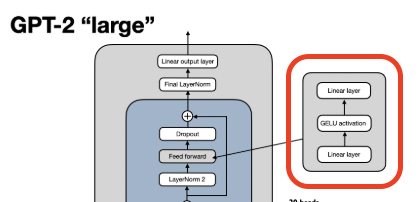

### 5.1 In-Linear Transformation

In [20]:
in_linear = nn.Linear(emd_dim, 4 * emd_dim)

### 5.2 GELU
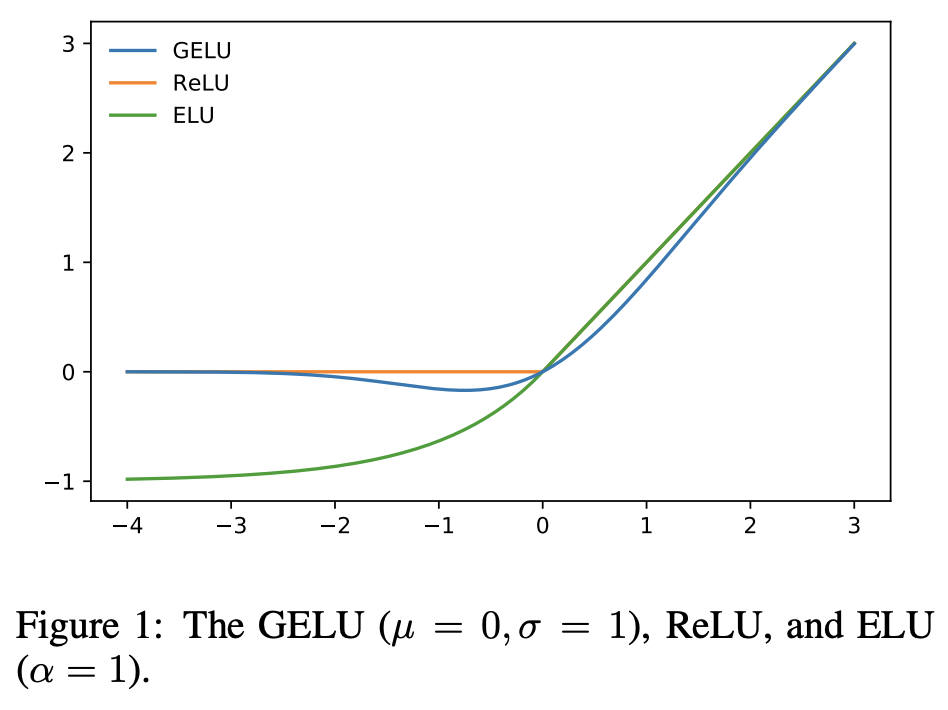


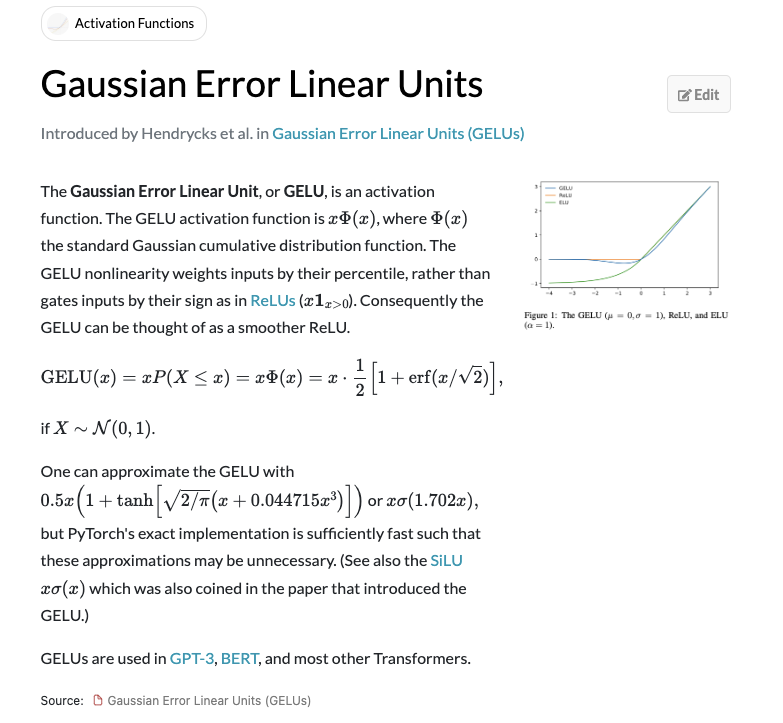

In [23]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, in_tensor):
        gelu = lambda x : (0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
                (x + 0.044715 * torch.pow(x, 3)))))
        return gelu (in_tensor)


### 5.3 Out-Linear Transformation

In [25]:
out_linear = nn.Linear(4 * emd_dim, emd_dim)

### 5.4 Feed Forward - complete sequence

In [26]:
ff_layers = nn.Sequential(in_linear, GELU(), out_linear)

In [27]:
result = ff_layers(final_norm_result)
print(result[0,:,:])
result.shape  # batch_size * in_seq_len * emd_dim

tensor([[-3.6307e-01, -6.8640e-01, -6.3997e-02, -1.3526e-01, -8.6914e-02,
          1.6783e-01, -4.3294e-01,  2.1119e-01,  3.8248e-01, -1.1650e-01],
        [-1.4384e-02, -4.9887e-01, -1.3506e-01, -1.8276e-02,  3.7050e-02,
          7.7078e-02, -4.1346e-01, -4.5419e-02, -3.5433e-03, -1.8929e-01],
        [ 1.0552e-01,  3.2832e-01,  1.6793e-01, -1.4825e-01,  2.2639e-01,
          1.8466e-01, -2.5970e-01,  1.8129e-01,  2.8479e-02,  3.7459e-01],
        [-2.1630e-01, -8.1299e-01,  2.2317e-01, -4.8191e-01, -3.3098e-01,
         -2.9184e-01, -7.7024e-01,  1.8049e-01,  8.9890e-02, -1.0285e-01],
        [ 2.6605e-02, -1.3847e-02,  9.4615e-02,  2.3939e-01, -4.5326e-02,
         -2.5203e-01, -2.8069e-01,  1.8266e-01,  2.0407e-01,  2.9311e-01],
        [-1.6568e-01, -6.6921e-05,  7.1267e-02, -4.8991e-02,  2.4265e-01,
          1.4705e-01, -3.7055e-01, -5.7069e-02,  4.7673e-01,  2.8605e-01],
        [-2.0213e-01,  1.2127e-01,  1.9013e-01, -1.8531e-01,  1.1974e-01,
          9.5606e-02, -6.4244e-0

torch.Size([3, 7, 10])

## 6. Dropout

In [28]:
result = dropout(result)
result.shape  # batch_size * in_seq_len * emd_dim

torch.Size([3, 7, 10])

## 7. Add Intermediate result back

In [29]:
result = result + intermediate_result
print(result[0,:,:])
result.shape  # batch_size * in_seq_len * emd_dim

tensor([[ 2.0286e+00, -9.6639e-01,  2.4549e+00,  1.7728e+00, -1.2435e+00,
         -3.8196e-01, -1.1635e+00, -1.0265e+00,  6.8671e-02,  2.7102e+00],
        [ 4.2745e-01, -5.6641e+00, -8.7659e-01,  5.8670e-01, -6.7667e-01,
         -1.8310e+00, -1.0007e+00,  1.8683e+00,  1.2626e+00,  1.1679e+00],
        [-1.9806e+00,  3.0596e-01,  3.7116e-01, -1.8251e+00,  8.0725e-01,
         -4.6488e-01,  9.6765e-01, -1.1712e+00, -1.5209e-01, -1.5795e+00],
        [-4.1995e-01, -1.3344e+00,  2.1212e+00, -1.5248e+00, -5.4829e-01,
         -5.5751e-01, -5.5705e-01,  5.6030e-01,  5.3765e-01,  2.4728e+00],
        [ 3.5512e-01, -6.9710e-02, -2.9245e-01, -2.6308e+00,  8.5664e-01,
          1.7543e+00,  1.1934e+00, -6.8300e-01, -1.7009e+00,  1.8971e+00],
        [-1.9798e+00, -1.6613e-01, -6.3532e-01,  1.7691e+00, -1.0017e+00,
          9.2729e-01, -2.1919e+00,  4.8061e-01, -1.2203e-01,  8.6797e-01],
        [-1.3188e+00,  1.6947e+00,  3.9995e-01,  2.5934e-01, -2.3737e+00,
         -6.2285e-01,  9.0836e-0

torch.Size([3, 7, 10])

### _Note_
The scripts 2_transformer.ipynb, 3_masked_multi_head_attention.ipynb and 4_continued_transformer.ipynb
are to be run sequentially "n_layer" times.
For Example:

```
n_layers = 36
transformer_block = nn.Sequential(*[TransformerBlock for _ in range(n_layers)])
```

## 8. Save to carry forward

In [30]:
torch.save(result,"intermediate_values/transformer_block_output.pt")